In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

!pip install folium==0.5.0
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter
import requests

#mport requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from scipy.optimize import curve_fit # Logistic regression

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
print('Libraries Imported')

     |████████████████████████████████| 112kB 31.0MB/s eta 0:00:01
Libraries Imported


## Data Sourcing

In [2]:
# load ny covid daily counts csv
ny_covid_daily_counts_df = pd.read_csv('https://raw.githubusercontent.com/nkkoratp/capstone_data_science_project/master/ny_covid_daily_counts.csv',index_col='Date')
ny_covid_daily_counts_df.head()

# load ny covid cases by borough csv
ny_covid_by_borough_df = pd.read_csv('https://raw.githubusercontent.com/nkkoratp/capstone_data_science_project/master/ny_covid_by_boroughs.csv', index_col='Borough')
ny_covid_by_borough_df.head()

# load ny covid cases by age csv
ny_covid_by_age_df = pd.read_csv('https://raw.githubusercontent.com/nkkoratp/capstone_data_science_project/master/ny_covid_by_age.csv',index_col='Age Group')
ny_covid_by_age_df.head()

# load ny covid cases by gender csv
ny_covid_by_gender_df = pd.read_csv('https://raw.githubusercontent.com/nkkoratp/capstone_data_science_project/master/ny_covid_by_gender.csv',index_col='Gender')
ny_covid_by_gender_df.head()

# load nyc boroughs geojson
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
nyc_geo = r'newyork_data.json'

# load NY city borough census data : 65 + years
ny_65_above_boroughs_df = pd.read_csv('https://raw.githubusercontent.com/nkkoratp/capstone_data_science_project/master/ny_boroughs_age_population.csv',index_col='Borough')
ny_65_above_boroughs_df.head()

# load a simplistic nyc boroughs geojson
!wget -q -O 'nyc_data.json' https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/new-york-city-boroughs.geojson
nyc_geo_2 = r'nyc_data.json'

print('Data downloaded!')

Data downloaded!


## Data Visualization

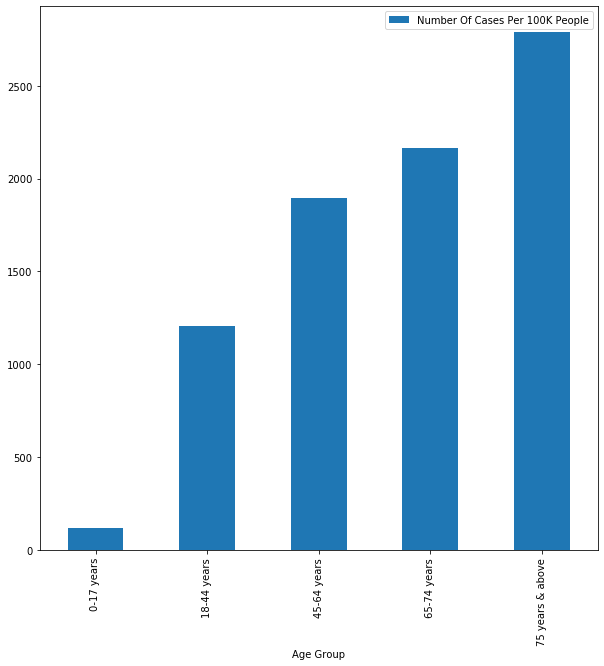

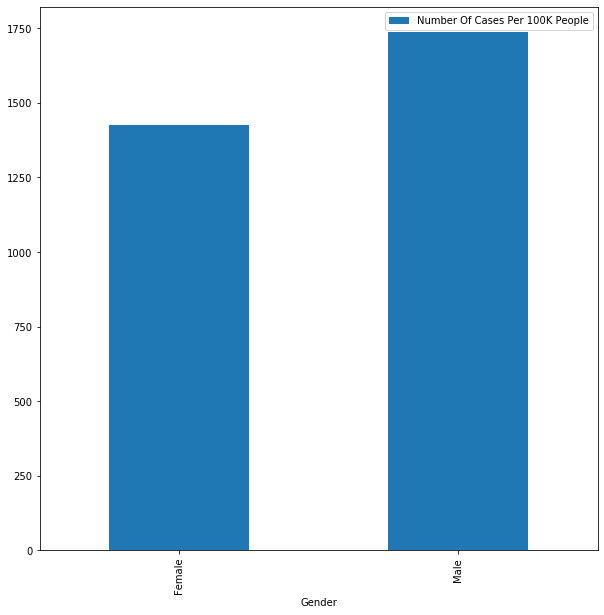

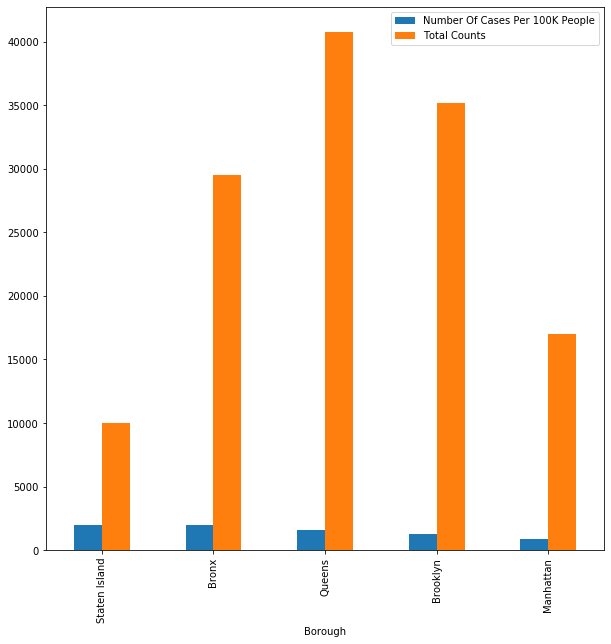

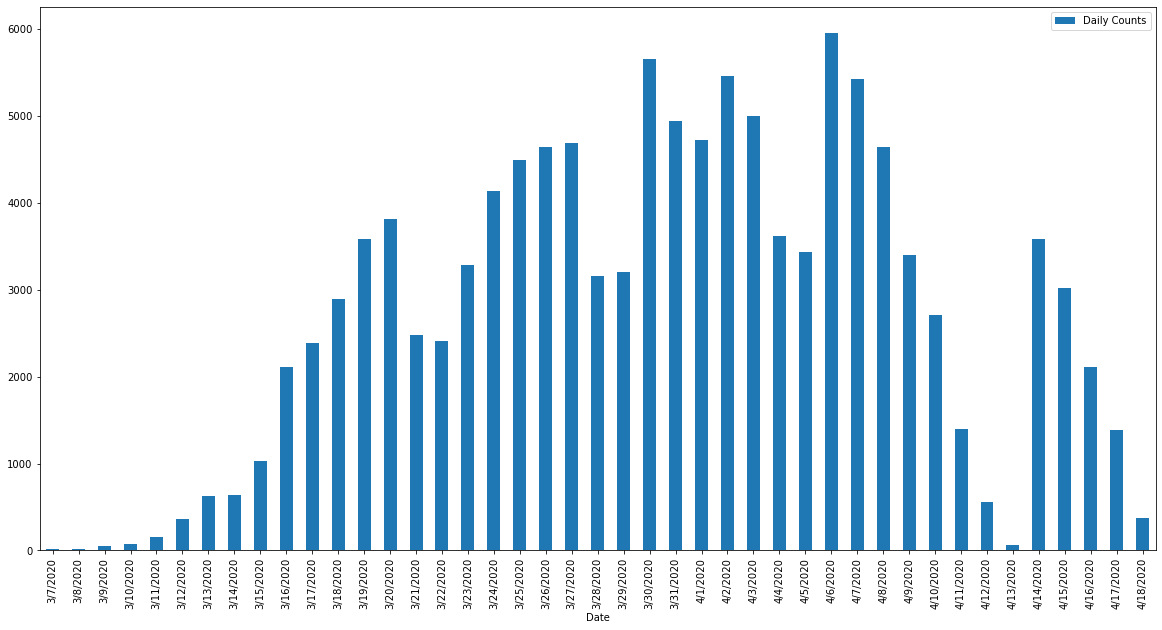

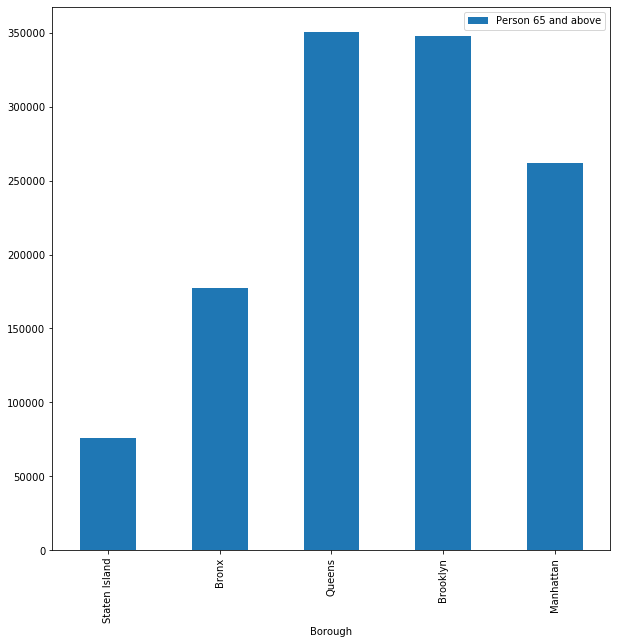

In [3]:
# visualize ny covid case - by age
ny_covid_by_age_df.plot(kind='bar',legend=True,figsize=(10,10))

# visualize ny covid case - by gender
ny_covid_by_gender_df.plot(kind='bar',legend=True,figsize=(10,10))

# visualize ny covid case - by borough
ny_covid_by_borough_df.plot(kind='bar',legend=True,figsize=(10,10))

# visualize ny covid case - by date
ny_covid_daily_counts_df.plot(kind='bar',legend=True,figsize=(20,10))

# visualize ny covid case - by boroughs with 65 + years of age
ny_65_above_boroughs_df.plot(kind='bar',legend=True,figsize=(10,10))

## Foursquare API 

In [4]:
CLIENT_ID = 'UA0R0KYNOMC1QQBURRIUPMO3BXJDV5JPJBONEBQQBDG5FHMZ' # your Foursquare ID
CLIENT_SECRET = '2S41RJYWFK5HYEHH0J2XNILXAJOHXCHQJOBWV54HCXEHK0SX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UA0R0KYNOMC1QQBURRIUPMO3BXJDV5JPJBONEBQQBDG5FHMZ
CLIENT_SECRET:2S41RJYWFK5HYEHH0J2XNILXAJOHXCHQJOBWV54HCXEHK0SX


In [5]:
# get lat/long for each nyc boroughs
borough_list = ['Bronx','Brooklyn','Manhattan','Staten Island','Queens']

# instantiate the dataframe
borough_location_df = pd.DataFrame(columns=['Borough','Latitude','Longitude'])

borough_location=[]
for borough in borough_list:
    address=borough + ', New York, NY'
    # add delay to avoid timeouts ..
    geolocator = Nominatim(user_agent="nyc_agent")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    borough_location_df = borough_location_df.append({'Borough':borough,'Latitude': latitude,'Longitude': longitude}, ignore_index=True)
borough_location_df

,Borough,Latitude,Longitude
0,Bronx,40.846651,-73.878594
1,Brooklyn,40.650104,-73.949582
2,Manhattan,40.789624,-73.959894
3,Staten Island,40.583456,-74.149605
4,Queens,40.749824,-73.797634


## Locate Hospitals in Boroughs

In [6]:
# Define URL. Medical centers in a mile ..
# [works/original] search_query = 'Medical'
search_query = 'Medical Emergency Hospital'

radius = 10000

# instantiate the dataframe
borough_med_loc_df = pd.DataFrame(columns=['Borough','Medical Center','Latitude','Longitude'])

# instatiate empty df list
medical_loc_df_list =[]

# for loop.ite rate over all borough lat/lon and get corresponding medical centers for each borough

for row in borough_location_df.itertuples(index=False):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, row.Latitude, row.Longitude, VERSION, search_query, radius, LIMIT)
   
    # Send the GET Request and examine the results
    results = requests.get(url).json()
    
    # assign relevant part of JSON to venues
    medical_loc = results['response']['venues']

    # tranform venues into a dataframe
    medical_loc_df = json_normalize(medical_loc)
    medical_loc_df['Borough']=row.Borough
    medical_loc_df=medical_loc_df[['Borough','name','location.lat','location.lng']]
    medical_loc_df_list.append(medical_loc_df)

medical_venue_loc_df = pd.concat(medical_loc_df_list)
medical_venue_loc_df.rename(columns={'name':'Medical Center','location.lat':'Latitude','location.lng':'Longitude'},inplace=True)
medical_venue_loc_df.set_index("Borough",inplace=True)
medical_venue_loc_df.head(200)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,Medical Center,Latitude,Longitude
Borough,,,
Bronx,EHMC - Englewood Hospital and Medical Center,40.904010,-73.968415
Bronx,New York Presbyterian Hospital Weill Cornell M...,40.764802,-73.954055
Bronx,St. Barnabas Hospital,40.852741,-73.891168
Bronx,Bronx-Lebanon Hospital Center Pediatric Emerge...,40.843309,-73.911491
Bronx,Joint Center at University Hospital and Medica...,40.844682,-73.940931
...,...,...,...
Queens,VA Medical Center - St. Albans,40.690853,-73.768519
Queens,Lincoln Hospital Emergency Room,40.817250,-73.920244
Queens,Westchester Square Medical Center,40.840897,-73.848290


Borough
Bronx            50
Brooklyn         43
Manhattan        50
Queens           37
Staten Island     5
Name: Medical Center, dtype: int64


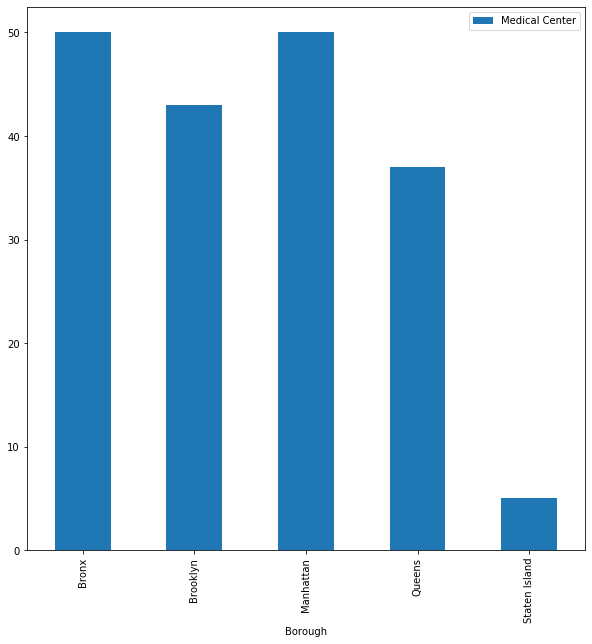

In [7]:
# count Medical centers by Borough
medical_venue_loc_group_df=medical_venue_loc_df['Medical Center']
medical_venue_loc_group_df.groupby("Borough").count().plot(kind='bar',legend=True,figsize=(10,10))
print(medical_venue_loc_group_df.groupby("Borough").count())

In [8]:
# reset_index. i.e. add the unlabeled column with values 0,1,2,3 .... otherwise, messing up the choropleth map
ny_covid_by_borough_df = ny_covid_by_borough_df.reset_index()

# reset index for med_venue_loc too
medical_venue_loc_df=medical_venue_loc_df.reset_index()

In [9]:
# Map the Medical Center on NYC map
# TODO location.lat/lng, is only for the last entry[borough] in for loop from previous cell... need to get medical location for all Boroughs ....
nyc_lat = 40.7127281
nyc_lon = -74.0060152
nyc_map = folium.Map(location=[nyc_lat, nyc_lon], zoom_start=11, tiles='OpenStreetMap')

nyc_map.choropleth(
    geo_data=nyc_geo_2,
    data=ny_covid_by_borough_df,
    columns=['Borough', 'Total Counts'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='NY Borogh COVID counts',
    reset=True
)

# add markers to map @ Medical center location
for borough, med_center, lat, lng in zip(medical_venue_loc_df['Borough'], medical_venue_loc_df['Medical Center'],medical_venue_loc_df['Latitude'], medical_venue_loc_df['Longitude']):
    label = '{}, {}'.format(med_center, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.Marker(
    location=[lat, lng],
    popup=label,
    icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(nyc_map)
 
display(nyc_map)

## Machine Learning Model

In [10]:
# can we predict the number of daily covid cases ..
ny_covid_daily_counts_df = ny_covid_daily_counts_df.reset_index()
ny_covid_daily_counts_df.head()

,Date,Daily Counts
0,3/7/2020,14
1,3/8/2020,20
2,3/9/2020,54
3,3/10/2020,75
4,3/11/2020,157


In [11]:
# format the date->datetime
ny_covid_daily_counts_df['Date'] = pd.to_datetime(ny_covid_daily_counts_df['Date'])

# datetime->milliseconds [float]
ny_covid_daily_counts_df['date_delta'] = (ny_covid_daily_counts_df['Date'] - ny_covid_daily_counts_df['Date'].min())  / np.timedelta64(1,'D')
ny_covid_daily_counts_df['date_delta']

# use the milliseconds[float] version for data. Plus its a delta, so first date is 0, next date is 1 and so on ..
x_data = ny_covid_daily_counts_df['date_delta'].values
y_data = ny_covid_daily_counts_df["Daily Counts"].values

In [12]:
# Lets normalize our data
#xdata_norm =x_data/max(x_data)
ydata_norm =y_data/max(y_data)

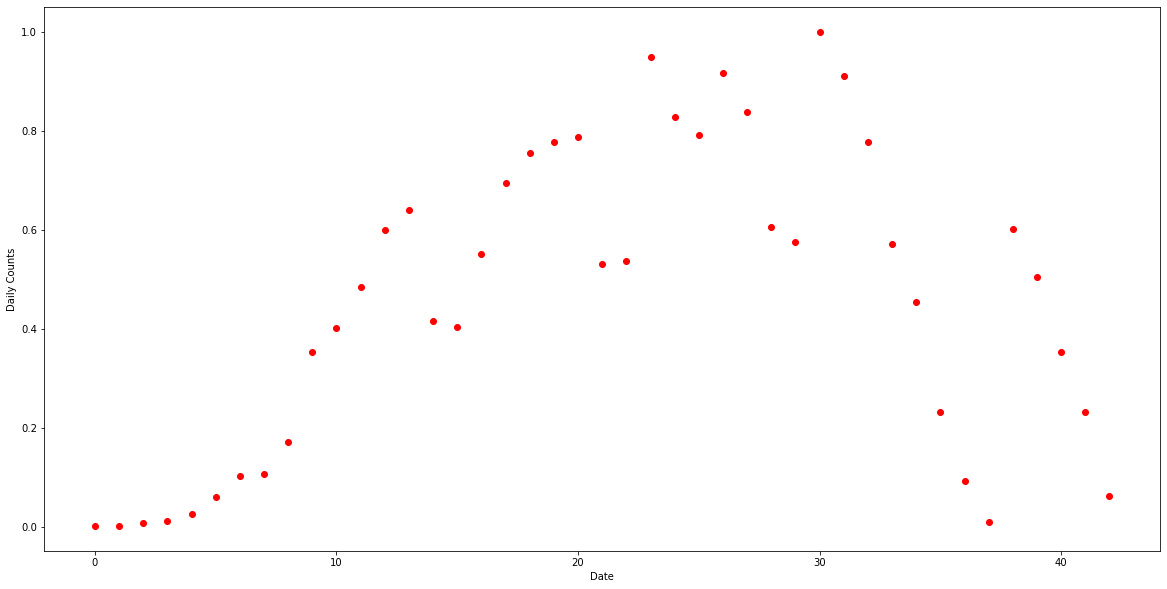

In [13]:
# see if the data is linear/non-linear
plt.figure(figsize=(20,10))
plt.plot(x_data, ydata_norm, 'ro')
plt.ylabel('Daily Counts')
plt.xlabel('Date')
plt.show()

In [14]:
# based on the above curve, the data seems to be Logistic [non-linear]. 
# hence we need to build a logistic regression machine learing predictive mode
# we need to tune the beta1, beta2 until we get a good curve fit ..
# now build our regression model and initialize its params
def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     #y = 1 / (1 + np.exp(-(x-Beta_2)/Beta_1))

     return y

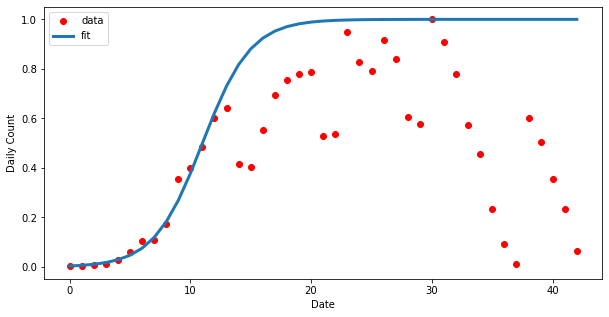

In [15]:
# Lets look at a sample sigmoid line that might fit with the data:
beta_1 = 0.5
beta_2 = 11

# logistic function
Y_pred = sigmoid(x_data, beta_1 , beta_2)

plt.figure(figsize=(10,5))

# plot actual data points
plt.plot(x_data, ydata_norm, 'ro', label='data')

# plot predicted data points
plt.plot(x_data, Y_pred, linewidth=3.0, label='fit')

plt.legend(loc='best')
plt.ylabel('Daily Count')
plt.xlabel('Date')
plt.show()

In [16]:
# Model Accuracy
from scipy.optimize import curve_fit
# split data into train/test
msk = np.random.rand(len(ny_covid_daily_counts_df)) < 0.8
train_x = x_data[msk]
test_x = x_data[~msk]
train_y = ydata_norm[msk]
test_y = ydata_norm[~msk]

# build the model using train set
popt, pcov = curve_fit(sigmoid, train_x, train_y)

# predict using test set
y_hat = sigmoid(test_x, *popt)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

Mean absolute error: 0.35
Residual sum of squares (MSE): 0.12
R2-score: -24.49


In [17]:
# correlation between cases and # people with 65 +
ny_65_above_boroughs_df = ny_65_above_boroughs_df.reset_index()
borough_65_corr_df=ny_covid_by_borough_df
borough_65_corr_df['Person 65 and above']=ny_65_above_boroughs_df['Person 65 and above']
borough_65_corr_df

,Borough,Number Of Cases Per 100K People,Total Counts,Person 65 and above
0,Staten Island,1990,9986,75935
1,Bronx,2005,29505,177294
2,Queens,1624,40714,350224
3,Brooklyn,1297,35203,348154
4,Manhattan,900,16987,261669


,Number Of Cases Per 100K People,Total Counts,Person 65 and above
Number Of Cases Per 100K People,1.000000,-0.035890,-0.605194
Total Counts,-0.035890,1.000000,0.805686
Person 65 and above,-0.605194,0.805686,1.000000


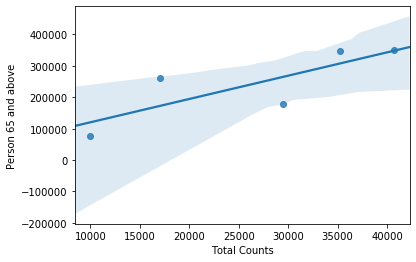

In [18]:
import seaborn as sns
#borough_65_corr_df=borough_65_corr_df.reset_index()
#plt.scatter(x=borough_65_corr_df['Total Counts'],y=borough_65_corr_df['Person 65 and above'],Regression_line)
ax = sns.regplot(x=borough_65_corr_df['Total Counts'], y=borough_65_corr_df['Person 65 and above'], scatter=True, fit_reg=True)
borough_65_corr_df.corr()